1.The Below cell is to grant access to your google drive so that you can mount your google drive to the note book and use the necessary pre-requisite files to run the program.  

2.once you run the below cell you'll be provided with a link which will provide a security ID please copy and paste it below.

3. Please make sure that all the files which are provided in the read me are uploaded into your drive location "/content/drive".  


 

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Please make sure to use the compatable Keras version. The latest existing Keras version had some issues while during training hence using the right version with supports my usecase. The below cell uninstalls Keras.

In [0]:
!pip uninstall q keras


The Below cell installs the right Keras version needed.

In [0]:
!pip install q keras==2.2.4

import keras
print(keras.__version__)

To view your google drive folder path and copy the required files into the colab.
Here in my case i have uploaded the pre-requiste files to my Google drive these files will be shared with you.
*Please change the path to respective google drive path where the files have been shared*.

In [0]:
!ls "/content/drive/My Drive/yolo"


In [0]:
!cp -R "/content/drive/My Drive/yolo" "/content/"
!cp "/content/drive/My Drive/yolo/dog.jpg" "yolo/dog.jpg"
!cp "/content/drive/My Drive/yolo/horses.jpg" "yolo/horses.jpg"
!cp "/content/drive/My Drive/yolo/person.jpg" "yolo/person.jpg"
!cp "/content/drive/My Drive/yolo/ellen.jpg" "yolo/ellen.jpg"
!cp "/content/drive/My Drive/yolo/selfie.jpg" "yolo/selfie.jpg"
!cp "/content/drive/My Drive/yolo/beach.jpg" "yolo/beach.jpg"
!cp "/content/drive/My Drive/yolo/two_dogs.jpg" "yolo/two_dogs.jpg"

## Data preprocessing

We will be looking at the [Pascal VOC dataset] for my usecase. Pasacal VOC dataset is one of the widely used publicly available object detection dataset.
It consists of total of 20 classes along with its respective annotations with nearly 6000 images to train.

Run the below cell to download and untar the dataset


In [0]:
!wget http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar


In [0]:
!tar xf VOCtrainval_11-May-2012.tar

Along with the images, there are also annotations - bounding boxes showing where each object is. These were hand labeled by Pascal voc dataset team.The original version were in XML, which is a little hard to work with nowadays,so I use the more recent JSON version.

The Below cell downloads and unzips the JSON files which is officialy released by Pascal VOC team.


In [0]:
! wget 'https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip'
! unzip 'PASCAL_VOC.zip'

### YOLO v3 preprocessing


The Below cell Downloads the Yolov3 weights from Darknet framework.

In [0]:
from pathlib import Path
path = Path('yolo')

! wget 'https://pjreddie.com/media/files/yolov3.weights' -P {path}

This below cell Reads Darknet config and weights and converts back into Keras model with Tensorflow background.
This below code snippet was provided by Keras official i have used the required code and made changes wrt to the usecase.

In [0]:

"""
Reads Darknet config and weights and creates Keras model with TF backend.

"""
import configparser
import io
import os
from collections import defaultdict

import numpy as np
from keras import backend as K
from keras.layers import (Conv2D, Input, ZeroPadding2D, Add,
                          UpSampling2D, MaxPooling2D, Concatenate)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model as plot


config_path = path/'yolov3.cfg'
weights_path = path/'yolov3.weights'
output_path = path/'yolov3.h5'

def unique_config_sections(config_file):
    """Convert all config sections to have unique names.

    Adds unique suffixes to config sections for compability with configparser.
    """
    section_counters = defaultdict(int)
    output_stream = io.StringIO()
    with open(config_file) as fin:
        for line in fin:
            if line.startswith('['):
                section = line.strip().strip('[]')
                _section = section + '_' + str(section_counters[section])
                section_counters[section] += 1
                line = line.replace(section, _section)
            output_stream.write(line)
    output_stream.seek(0)
    return output_stream

config_path = os.path.expanduser(config_path)
weights_path = os.path.expanduser(weights_path)
assert config_path.endswith('.cfg'), '{} is not a .cfg file'.format(
    config_path)
assert weights_path.endswith(
    '.weights'), '{} is not a .weights file'.format(weights_path)

output_path = os.path.expanduser(output_path)
assert output_path.endswith(
    '.h5'), 'output path {} is not a .h5 file'.format(output_path)
output_root = os.path.splitext(output_path)[0]

# Load weights and config.
print('Loading weights.')
weights_file = open(weights_path, 'rb')
major, minor, revision = np.ndarray(
    shape=(3, ), dtype='int32', buffer=weights_file.read(12))
if (major*10+minor)>=2 and major<1000 and minor<1000:
    seen = np.ndarray(shape=(1,), dtype='int64', buffer=weights_file.read(8))
else:
    seen = np.ndarray(shape=(1,), dtype='int32', buffer=weights_file.read(4))
print('Weights Header: ', major, minor, revision, seen)

print('Parsing Darknet config.')
unique_config_file = unique_config_sections(config_path)
cfg_parser = configparser.ConfigParser()
cfg_parser.read_file(unique_config_file)

print('Creating Keras model.')
input_layer = Input(shape=(None, None, 3))
prev_layer = input_layer
all_layers = []

weight_decay = float(cfg_parser['net_0']['decay']
                     ) if 'net_0' in cfg_parser.sections() else 5e-4
count = 0
out_index = []
for section in cfg_parser.sections():
    print('Parsing section {}'.format(section))
    if section.startswith('convolutional'):
        filters = int(cfg_parser[section]['filters'])
        size = int(cfg_parser[section]['size'])
        stride = int(cfg_parser[section]['stride'])
        pad = int(cfg_parser[section]['pad'])
        activation = cfg_parser[section]['activation']
        batch_normalize = 'batch_normalize' in cfg_parser[section]

        padding = 'same' if pad == 1 and stride == 1 else 'valid'

        # Setting weights.
        # Darknet serializes convolutional weights as:
        # [bias/beta, [gamma, mean, variance], conv_weights]
        prev_layer_shape = K.int_shape(prev_layer)

        weights_shape = (size, size, prev_layer_shape[-1], filters)
        darknet_w_shape = (filters, weights_shape[2], size, size)
        weights_size = np.product(weights_shape)

        print('conv2d', 'bn'
              if batch_normalize else '  ', activation, weights_shape)

        conv_bias = np.ndarray(
            shape=(filters, ),
            dtype='float32',
            buffer=weights_file.read(filters * 4))
        count += filters

        if batch_normalize:
            bn_weights = np.ndarray(
                shape=(3, filters),
                dtype='float32',
                buffer=weights_file.read(filters * 12))
            count += 3 * filters

            bn_weight_list = [
                bn_weights[0],  # scale gamma
                conv_bias,  # shift beta
                bn_weights[1],  # running mean
                bn_weights[2]  # running var
            ]

        conv_weights = np.ndarray(
            shape=darknet_w_shape,
            dtype='float32',
            buffer=weights_file.read(weights_size * 4))
        count += weights_size

        # DarkNet conv_weights are serialized Caffe-style:
        # (out_dim, in_dim, height, width)
        # We would like to set these to Tensorflow order:
        # (height, width, in_dim, out_dim)
        conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])
        conv_weights = [conv_weights] if batch_normalize else [
            conv_weights, conv_bias
        ]

        # Handle activation.
        act_fn = None
        if activation == 'leaky':
            pass  # Add advanced activation later.
        elif activation != 'linear':
            raise ValueError(
                'Unknown activation function `{}` in section {}'.format(
                    activation, section))

        # Create Conv2D layer
        if stride>1:
            # Darknet uses left and top padding instead of 'same' mode
            prev_layer = ZeroPadding2D(((1,0),(1,0)))(prev_layer)
        conv_layer = (Conv2D(
            filters, (size, size),
            strides=(stride, stride),
            kernel_regularizer=l2(weight_decay),
            use_bias=not batch_normalize,
            weights=conv_weights,
            activation=act_fn,
            padding=padding))(prev_layer)

        if batch_normalize:
            conv_layer = (BatchNormalization(
                weights=bn_weight_list))(conv_layer)
        prev_layer = conv_layer

        if activation == 'linear':
            all_layers.append(prev_layer)
        elif activation == 'leaky':
            act_layer = LeakyReLU(alpha=0.1)(prev_layer)
            prev_layer = act_layer
            all_layers.append(act_layer)

    elif section.startswith('route'):
        ids = [int(i) for i in cfg_parser[section]['layers'].split(',')]
        layers = [all_layers[i] for i in ids]
        if len(layers) > 1:
            print('Concatenating route layers:', layers)
            concatenate_layer = Concatenate()(layers)
            all_layers.append(concatenate_layer)
            prev_layer = concatenate_layer
        else:
            skip_layer = layers[0]  # only one layer to route
            all_layers.append(skip_layer)
            prev_layer = skip_layer

    elif section.startswith('maxpool'):
        size = int(cfg_parser[section]['size'])
        stride = int(cfg_parser[section]['stride'])
        all_layers.append(
            MaxPooling2D(
                pool_size=(size, size),
                strides=(stride, stride),
                padding='same')(prev_layer))
        prev_layer = all_layers[-1]

    elif section.startswith('shortcut'):
        index = int(cfg_parser[section]['from'])
        activation = cfg_parser[section]['activation']
        assert activation == 'linear', 'Only linear activation supported.'
        all_layers.append(Add()([all_layers[index], prev_layer]))
        prev_layer = all_layers[-1]

    elif section.startswith('upsample'):
        stride = int(cfg_parser[section]['stride'])
        assert stride == 2, 'Only stride=2 supported.'
        all_layers.append(UpSampling2D(stride)(prev_layer))
        prev_layer = all_layers[-1]

    elif section.startswith('yolo'):
        out_index.append(len(all_layers)-1)
        all_layers.append(None)
        prev_layer = all_layers[-1]

    elif section.startswith('net'):
        pass

    else:
        raise ValueError(
            'Unsupported section header type: {}'.format(section))

# Create and save model.
if len(out_index)==0: out_index.append(len(all_layers)-1)
model = Model(inputs=input_layer, outputs=[all_layers[i] for i in out_index])
print(model.summary())

# model.save_weights('{}'.format(output_path))
# print('Saved Keras weights to {}'.format(output_path))

model.save('{}'.format(output_path))
print('Saved Keras model to {}'.format(output_path))

# Check to see if all weights have been read.
remaining_weights = len(weights_file.read()) / 4
weights_file.close()
print('Read {} of {} from Darknet weights.'.format(count, count +
                                                   remaining_weights))
if remaining_weights > 0:
    print('Warning: {} unused weights'.format(remaining_weights))

Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.


Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)









Parsing section convolutional_1
conv2d bn leaky (3, 3, 32, 64)
Parsing section convolutional_2
conv2d bn leaky (1, 1, 64, 32)
Parsing section convolutional_3
conv2d bn leaky (3, 3, 32, 64)
Parsing section shortcut_0
Parsing section convolutional_4
conv2d bn leaky (3, 3, 64, 128)
Parsing section convolutional_5
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_6
conv2d bn leaky (3, 3, 64, 128)
Parsing section shortcut_1
Parsing section convolutional_7
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_8
conv2d bn leaky (3, 3, 64, 128)
Parsing section shortcut_2
Parsing section convolutional_9
conv2d bn leaky (3, 3, 128, 256)
Parsing section convolutional_10
conv2d bn leaky (1, 1, 256, 128)
Parsing section convolutional_11
conv2d bn leaky (3, 3, 128, 256)
Parsing section short

In [0]:
import xml.etree.ElementTree as ET
from os import getcwd

sets=[('2012', 'train'), ('2012', 'val')]

classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


def convert_annotation(year, image_id, list_file):
    print(year,image_id)
    in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

wd = getcwd()

for year, image_set in sets:
    image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
    list_file = open('%s_%s.txt'%(year, image_set), 'w')
    for image_id in image_ids:
        list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
        convert_annotation(year, image_id, list_file)
        list_file.write('\n')
    list_file.close()

os.system("cat 2012_train.txt 2012_val.txt > train.txt")

## TRAINING



Import the necessary modules to train the YOLOv3 model with keras and tensorflow.

In [0]:
import numpy as np
import time
import keras.backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Lambda
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from PIL import Image
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

from yolo.model import preprocess_true_boxes, yolo_body, yolo_loss
from yolo.utils import get_random_data, draw_boxes, get_colors_for_classes

In [0]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [0]:
def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='yolo/yolov3.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

In [0]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

The Training part is commented for now because the model is alreaded trained and ttained pickle weights are shared in the link provided in readme

In [0]:
# annotation_path = '2012_train.txt'
# log_dir = 'yolo/logs/'
# classes_path = 'yolo/voc_classes.txt'
# anchors_path = 'yolo/yolo_anchors.txt'
# class_names = get_classes(classes_path)
# num_classes = len(class_names)
# anchors = get_anchors(anchors_path)

# input_shape = (416, 416)  # multiple of 32, hw

# model = create_train_model(input_shape, anchors, num_classes,
#                       freeze_body=2, weights_path='/content/drive/My Drive/trained_weights_stage_1.h5') # make sure you know what you freeze

# logging = TensorBoard(log_dir=log_dir)
# checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
#     monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# val_split = 0.1
# with open(annotation_path) as f:
#     lines = f.readlines()
# np.random.seed(10101)
# np.random.shuffle(lines)
# np.random.seed(None)
# num_val = int(len(lines)*val_split)
# num_train = len(lines) - num_val



In [0]:
# # # Train with frozen layers first, to get a stable loss.
# # # Adjust num epochs to .This step is enough to obtain a not bad model.
# if True:
#     model.compile(optimizer=Adam(lr=1e-3), loss={
#         # use custom yolo_loss Lambda layer.
#         'yolo_loss': lambda y_true, y_pred: y_pred})

#     batch_size = 32
#     print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
#     model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
#             steps_per_epoch=max(1, num_train//batch_size),
#             validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
#             validation_steps=max(1, num_val//batch_size),
#             epochs=20,
#             initial_epoch=0,
#             callbacks=[logging, checkpoint])
#     model.save_weights(log_dir + 'trained_weights_stage_1_weights.h5')
    


#     model.save(log_dir + 'trained_weights_stage_1_model.h5')

Retrain the model for better accurary and reduced loss

In [0]:
# # Unfreeze and continue training, to fine-tune.
# # Train longer if the result is not good.
# if True:
#     for i in range(len(model.layers)):
#         model.layers[i].trainable = True
#     model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
#     print('Unfreeze all of the layers.')

#     batch_size = 10 # more GPU memory is required after unfreezing the body
#     print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
#     model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
#         steps_per_epoch=max(1, num_train//batch_size),
#         validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
#         validation_steps=max(1, num_val//batch_size),
#         epochs=20,
#         callbacks=[logging, checkpoint, reduce_lr, early_stopping])
#     model.save_weights(log_dir + 'trained_weights_final_2.h5')

# #     #Further training if needed.
#     model.save(log_dir + 'yolov3_retrained_2.h5')

Unfreeze all of the layers.
Train on 5146 samples, val on 571 samples, with batch size 10.
Epoch 1/20
514/514 [==============================] - 495s 964ms/step - loss: 22.3971 - val_loss: 22.3633
Epoch 2/20
514/514 [==============================] - 484s 942ms/step - loss: 21.8324 - val_loss: 23.1855
Epoch 3/20
514/514 [==============================] - 490s 953ms/step - loss: 21.6494 - val_loss: 22.3298
Epoch 4/20
514/514 [==============================] - 485s 943ms/step - loss: 21.2633 - val_loss: 22.4904
Epoch 5/20
514/514 [==============================] - 489s 952ms/step - loss: 21.0306 - val_loss: 22.5634
Epoch 6/20
514/514 [==============================] - 481s 937ms/step - loss: 21.0138 - val_loss: 22.4533

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 7/20
514/514 [==============================] - 477s 929ms/step - loss: 19.8217 - val_loss: 21.6582
Epoch 8/20
514/514 [==============================] - 477s 928ms/step - loss: 19.1683 

### Inference/ Prediction
The below cells provide necessary steps to preprocess new image and run through trained model to generate predictions

In [0]:
import tensorflow as tf
def yolo_convert_final(feats, anchors, num_classes, input_shape, calc_loss=False):
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats[0]))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

def yolo_get_correct_boxes(box_xy, box_wh, input_shape, image_shape):
    '''Get corrected boxes'''
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = K.cast(input_shape, K.dtype(box_yx))
    image_shape = K.cast(image_shape, K.dtype(box_yx))
    new_shape = K.round(image_shape * K.min(input_shape/image_shape))
    offset = (input_shape-new_shape)/2./input_shape
    scale = input_shape/new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes =  K.concatenate([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ])

    # Scale boxes back to original image shape.
    boxes *= K.concatenate([image_shape, image_shape])
    return boxes


def yolo_box_scores(feats, anchors, num_classes, input_shape, image_shape):
    '''Process Conv layer output'''
    box_xy, box_wh, box_confidence, box_class_probs = yolo_convert_final(feats,
        anchors, num_classes, input_shape)
    boxes = yolo_get_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = K.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = K.reshape(box_scores, [-1, num_classes])
    return boxes, box_scores


def evaluate(yolo_outputs,
              anchors,
              num_classes,
              image_shape,
              max_boxes=20,
              score_threshold=.6,
              iou_threshold=.5):
    """Evaluate YOLO model on given input and return filtered boxes."""
    num_layers = len(yolo_outputs)
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]] # default setting
    input_shape = K.shape(yolo_outputs[0])[1:3] * 32
    boxes = []
    box_scores = []
    for l in range(num_layers):
        _boxes, _box_scores = yolo_box_scores(yolo_outputs[l],
            anchors[anchor_mask[l]], num_classes, input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = K.concatenate(boxes, axis=0)
    box_scores = K.concatenate(box_scores, axis=0)

    mask = box_scores >= score_threshold
    max_boxes_tensor = K.constant(max_boxes, dtype='int32')
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(num_classes):
        class_boxes = tf.boolean_mask(boxes, mask[:, c])
        class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])
        nms_index = tf.image.non_max_suppression(
            class_boxes, class_box_scores, max_boxes_tensor, iou_threshold=iou_threshold)
        class_boxes = K.gather(class_boxes, nms_index)
        class_box_scores = K.gather(class_box_scores, nms_index)
        classes = K.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)
    boxes_ = K.concatenate(boxes_, axis=0)
    scores_ = K.concatenate(scores_, axis=0)
    classes_ = K.concatenate(classes_, axis=0)

    return boxes_, scores_, classes_


Please do not change the paths as they were shared in respective folder structure.

In [0]:
sess = K.get_session()
classes_path = 'yolo/voc_classes.txt'
anchors_path = 'yolo/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)
input_shape=(416, 416)

Please replace path in yolo.load_weights with the trained file provided path. The trained model weights file is shared with you in the google drive please provide the necessary path 

In [0]:
yolo_model = yolo_body(Input(shape=(None, None, 3)), num_anchors//3, num_classes)
yolo_model.load_weights('/content/drive/My Drive/yolov3_retrained_2.h5')

In [0]:
yolo_model.summary()

In [0]:
def preprocess_image(image_path):    
    image = Image.open(image_path)
    new_image_size = (image.width - (image.width % 32),
                            image.height - (image.height % 32))
    resized_image = image.resize(new_image_size, Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')

    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) # Add batch dimension.

    return image_data, image

In [0]:
def predict(sess, image_path):
    
    start_time = time.time()
  
    image_data, image = preprocess_image(image_path)
    
    image_shape = image_data.shape[1:3]
    
    boxes, scores, classes = evaluate(yolo_model.output, anchors, num_classes, image_shape)

    out_boxes, out_scores, out_classes = sess.run([boxes, scores, classes], 
                                                  feed_dict={yolo_model.input:image_data,
                                                             K.learning_phase(): 0})
    print ("Time taken:", time.time()-start_time, "sec")
    print('Found {} boxes for {}'.format(len(out_boxes), image_path.split("/")[1]))
    
    colors = get_colors_for_classes(num_classes)

    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)

    output_path = "output_"+ str(image_path.split("/")[1])+ ".jpg"
    image.save(output_path, quality=90)

    output_image = Image.open(output_path)
    
    plt.grid(visible=False)
    plt.xticks([])
    plt.yticks([])
    imshow(output_image)

Please Provide few random images to run throught the model and generate prediction. Make sure that random images downloaded must be from the 20 trained classed. Since the Pascal VOC Dataset has 20 different claases to run.

*Few random unseen images by the model are downloaded from net are provided in the readme for testing. Please feel free to use those images for testing*. 


Make sure if you want to test with your images they must be with .jpg extension only. Other exetensions ar not supported.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Time taken: 7.173758506774902 sec
Found 7 boxes for ellen.jpg
person 1.00 (413, 50) (575, 314)
person 1.00 (193, 105) (548, 323)
person 0.99 (0, 15) (155, 314)
person 0.99 (96, 103) (313, 311)
person 0.91 (182, 9) (280, 107)
person 0.89 (309, 0) (436, 169)
person 0.61 (398, 27) (449, 84)


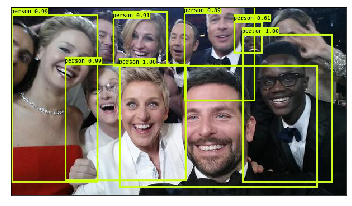

In [0]:
predict(sess, 'yolo/ellen.jpg')

Time taken: 3.6529855728149414 sec
Found 20 boxes for selfie.jpg
person 1.00 (1038, 758) (1352, 1119)
person 1.00 (706, 712) (1051, 1119)
person 1.00 (1339, 704) (1638, 1120)
person 0.99 (1822, 879) (2042, 1119)
person 0.99 (508, 864) (662, 1090)
person 0.99 (987, 776) (1100, 992)
person 0.99 (29, 692) (196, 927)
person 0.99 (620, 763) (757, 936)
person 0.99 (179, 497) (315, 668)
person 0.99 (274, 995) (523, 1121)
person 0.98 (1, 805) (172, 1123)
person 0.98 (1756, 668) (1910, 830)
person 0.98 (117, 891) (291, 1120)
person 0.97 (279, 848) (461, 1102)
person 0.97 (153, 704) (282, 909)
person 0.94 (472, 1014) (639, 1118)
person 0.94 (250, 402) (301, 499)
person 0.93 (1850, 699) (2027, 933)
person 0.91 (1653, 852) (1831, 1105)
person 0.91 (1940, 584) (2048, 852)


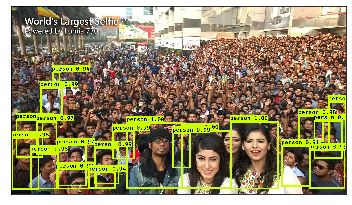

In [0]:
predict(sess, 'yolo/selfie.jpg')

Time taken: 3.731621503829956 sec
Found 4 boxes for horses.jpg
horse 1.00 (20, 193) (314, 417)
horse 1.00 (435, 219) (597, 344)
horse 0.99 (241, 195) (436, 359)
horse 0.98 (4, 174) (157, 415)


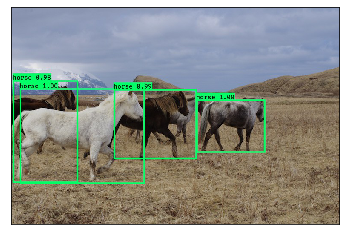

In [0]:
predict(sess, 'yolo/horses.jpg')

Time taken: 3.9368488788604736 sec
Found 4 boxes for person.jpg
dog 0.98 (61, 257) (203, 342)
horse 0.66 (413, 125) (596, 316)
person 0.99 (189, 93) (270, 382)
sheep 0.75 (418, 132) (610, 340)


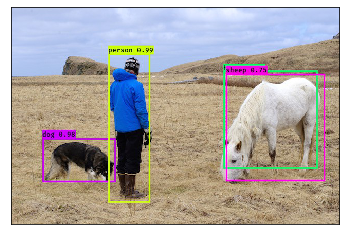

In [0]:
predict(sess, 'yolo/person.jpg')

Time taken: 4.402129650115967 sec
Found 4 boxes for beach.jpg
person 1.00 (113, 609) (163, 756)
person 0.99 (215, 699) (269, 847)
person 0.97 (80, 504) (106, 561)
person 0.62 (38, 510) (55, 555)


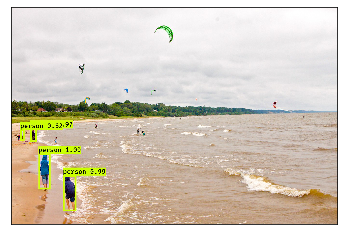

In [0]:
predict(sess, 'yolo/beach.jpg')